# UCLA Results Validation

This notebook is aimed at attemping to cross validate the results achieved but UCLA in their paper. 
Cross validation is done here by diving the dataset into k splits, taking 1 split for training, one for testing and k - 2 for training k times. The cross validation will also be stratisfied in the protest class, making sure we have a decent balance between protest and non protest images in all splits

In [1]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

/home/lucas/Documents/ITU/Thesis_2018/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

### Loading up the data

In [4]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


52366

Get the labels

In [5]:

cols = ["name", "label", "protest"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
split_tags = ['ucla-test', 'ucla-train']
imgs = imgs[cols + tag_cols + split_tags]
indx_non_violence = imgs['label'].isnull()

imgs.loc[:,tag_cols] = imgs.loc[:,tag_cols].astype(int)
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
000000000082a424,train-12406.jpg,0.155594,True,1,0,0,0,0,1,0,0,1,0,False,True
000000000082a424,train-12406.jpg,0.161231,True,1,0,0,0,0,1,0,0,1,0,False,True
0000002029cdaabb,test-04022.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
00000029ac7cfbf6,train-27220.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,False,True
0000004058d81484,train-14949.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,False,True
000000418c2301c1,train-27068.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,False,True
000000605090dcc5,train-10384.jpg,0.186273,True,1,0,0,0,0,1,0,0,0,0,False,True
000000605090dcc5,train-10384.jpg,0.193367,True,1,0,0,0,0,1,0,0,0,0,False,True
0000009220b2b209,train-06050.jpg,0.142335,True,1,0,0,0,0,0,0,0,0,0,False,True


### Pre-processing

In [6]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1
# df.loc[indx_non_violence, 'violence'] = -1

# masks the visual attributes that where image is not a protest
# for column, value in df.iloc[:,3:].iteritems(): # fill visual attributes with masking
#     df.loc[pd.isnull(df['protest']), column] = -1
imgs.loc[indx_non_violence, tag_cols] = -1
    
# fill nas
# df.fillna(0, inplace = True)

# df = imgs.rename(columns={"label": "violence"})
df = imgs
df

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
000000000082a424,train-12406.jpg,0.361846,True,1,0,0,0,0,1,0,0,1,0,False,True
000000000082a424,train-12406.jpg,0.374956,True,1,0,0,0,0,1,0,0,1,0,False,True
0000002029cdaabb,test-04022.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
00000029ac7cfbf6,train-27220.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,False,True
0000004058d81484,train-14949.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,False,True
000000418c2301c1,train-27068.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,False,True
000000605090dcc5,train-10384.jpg,0.433192,True,1,0,0,0,0,1,0,0,0,0,False,True
000000605090dcc5,train-10384.jpg,0.449691,True,1,0,0,0,0,1,0,0,0,0,False,True
0000009220b2b209,train-06050.jpg,0.331012,True,1,0,0,0,0,0,0,0,0,0,False,True


In [7]:
i = df['violence'].idxmax()
df.loc[i]

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
0612b7b33130304a,train-07477.jpg,1.0,True,0,0,1,0,0,1,0,0,0,0,False,True
0612b7b33130304a,train-07477.jpg,1.0,True,0,0,1,0,0,1,0,0,0,0,False,True


Get the images

In [8]:
n_folds = 5
seed = 300

In [9]:
df_relevant = df[["name", "violence", "protest"] + tag_cols]
k_folds = au.getKSplitsStratified(df_relevant, n_folds, "protest", seed )
for i in k_folds:
    print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

kfold has  4658 protest images and  5814 non protest images
kfold has  4658 protest images and  5814 non protest images
kfold has  4658 protest images and  5814 non protest images
kfold has  4658 protest images and  5814 non protest images
kfold has  4660 protest images and  5818 non protest images


In [10]:
# print first fold
k_folds[0]

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
b6c53b6b4d9bdb86,train-18421.jpg,0.139737,True,1,0,0,0,0,0,0,0,0,0
4bd7a9296543e162,test-04142.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
a7470cd2cc98891d,train-22892.jpg,0.248625,True,1,0,0,0,0,0,0,0,0,0
e9311210183a9855,train-13925.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
f4f4624898936072,train-04838.jpg,0.331490,True,1,0,0,0,0,1,0,1,0,0
39d9d3d219193919,train-29594.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8e8e2f69e9e54f60,train-15109.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
e17169634ed69600,train-14479.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
e9d1d3d3d3d3e060,train-23875.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [11]:
batch_size = 32

In [12]:

dummy_test_generator = au.ResizeSequence(
    df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32,)  visual has shape (32, 10)


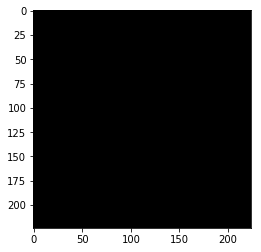

In [13]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
visual = first[1][2]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape, " visual has shape", visual.shape)

In [14]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 2; patience = 10

In [15]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

### Training

In [ ]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
size_sample = 34

k_folds_test = []
for i in k_folds:
    k_folds_test.append(i.copy()[:size_sample])
    
k_folds = k_folds_test # use this for testing with a smaller sample

In [ ]:
k_folds_iter = itertools.cycle(k_folds) # will cycle through it

for i in range(n_folds):
    split_name = 'split' + str(i)
    
    # gets val and test folds
    val_fold = next(k_folds_iter).copy()
    test_fold = next(k_folds_iter).copy()
    
    # gets training fold
    train_fold = None
    for i in range(n_folds - 2): # by definition
        if (train_fold is None):
            train_fold = next(k_folds_iter).copy()
        else:
            train_fold = train_fold.append(next(k_folds_iter).copy())
            
    
    # build generators
    train_generator = au.ResizeSequence(
        train_fold,
        batch_size, 
        targets = ['protest', 'violence', tag_cols],
        transforms = [
            transforms.randomResizedCrop,
            transforms.randomRotation,
            transforms.randomHorizontalFlip,
            transforms.colorJitter,
            transforms.normalizeMinMax,
            transforms.lighting,
            transforms.normalizeStandardScore
        ]
    )
    validation_generator = au.ResizeSequence(
        val_fold,
        batch_size, 
        targets = ['protest', 'violence', tag_cols],
        transforms = [
            transforms.resize,
            transforms.centerCrop,
            transforms.normalizeMinMax,
            transforms.normalizeStandardScore
        ]
    )
    
    test_generator = au.ResizeSequence(
    test_fold,
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

            
    print(split_name, "train size ", len(train_fold), "val size ", len(val_fold), "test size ", len(test_fold))
    
    
    # Modeling start
    Kbackend.clear_session()
    
    model = au.initializeUCLAModel()
    
    optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
    model.compile(optimizer=optimizer,
              loss={'protest_out': Klosses.binary_crossentropy,
                    'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
                    'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 5, 
                            'violence_out': 10 })
    #model.summary()

    try:
        __file__ # Apparently, this is not defined in the notebook,
             # but it will be when we start running on the server
             # (So when things gets real)
    except NameError:
        __file__ = "test"


    name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name, split_name)
    csv_results = "models_preds/%s.csv" % name
    model_checkout_path = "models/%s.hdf5" % name
    csv_logger_path = "logs/%s.csv" % name
    tensor_board_folder = os.path.join("logs", name)

    if not os.path.exists(tensor_board_folder):
        os.makedirs(tensor_board_folder)

    print("Writing model to: \t%s" % model_checkout_path)
    print("Writing log to: \t%s\n" % csv_logger_path)



    # callbacks
    change_lr = Kcallbacks.LearningRateScheduler(au.lrUpdateUCLA, 
                                                verbose = True)

    checkpoint = Kcallbacks.ModelCheckpoint(model_checkout_path,
                                           monitor='val_loss', 
                                           verbose=1,
                                           save_best_only=True,
                                           save_weights_only=False,
                                           mode='auto',
                                           period=1)

    earlystop = Kcallbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0, 
                                         patience=patience,
                                         verbose=1, 
                                         mode='auto')

    tensor_board = Kcallbacks.TensorBoard(log_dir=tensor_board_folder,
                                         histogram_freq=0,
                                         batch_size=32, 
                                         write_graph=True,
                                         write_grads=False, 
                                         write_images=False, 
                                         embeddings_freq=0,
                                         embeddings_layer_names=None,
                                         embeddings_metadata=None)

    csv_logger = Kcallbacks.CSVLogger(csv_logger_path, 
                                     separator=',', 
                                     append=False)

    history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop])

    
    # Preds
    
    preds = model.predict_generator(test_generator, verbose = 1)
    preds_protest = preds[0][:len(test_fold)] # avoid getting more than the needed
    preds_violence = preds[1][:len(test_fold)] 
    preds_visual = preds[2][:len(test_fold)] 
    print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape, "visual shape is ", preds_visual.shape)

    # Creates a panda data frame with the results
    
    test_fold_results = test_fold.copy()
    test_fold_results["pred_protest"] = preds_protest
    test_fold_results["pred_violence"] = preds_violence
    
    tag_cols_preds = ["pred_" + x for x in tag_cols]
    test_fold_results[tag_cols_preds] = pd.DataFrame(preds_visual, index = test_fold_results.index)
    
    print("saving results")
    test_fold_results.to_csv(csv_results)


split0 train size  102 val size  34 test size  34
Writing model to: 	models/test_datalen-52366_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300_split0.hdf5
Writing log to: 	logs/test_datalen-52366_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300_split0.csv

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
4/4 [==============================] - 141s 35s/step - loss: 2.0814 - protest_out_loss: 0.6587 - violence_out_loss: 0.0186 - visual_out_loss: 0.2473 - val_loss: 1.5505 - val_protest_out_loss: 0.5878 - val_violence_out_loss: 0.0253 - val_visual_out_loss: 0.1419

Epoch 00001: val_loss improved from inf to 1.55049, saving model to models/test_datalen-52366_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300_split0.hdf5
Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
4/4 [==============================] - 133s 33s/step - l